# ***Graph Neural Networks for End-to-End Particle Identification with the CMS Experiment***
### *written by Khalid Bagus Pratama Darmadi, S.Si (Khalid); Papua, Indonesia*
*for ML4SCI on Google Summer of Code 2023*

Common Task 2. Deep Learning based Quark-Gluon Classification
Datasets:

> https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL


Description: 125x125 matrices (three channel images) for two classes of particles quarks and gluons impinging on a calorimeter.
For a description of 1st dataset please refer to the link provided for the dataset.

Please use a Convolutional Neural Network (CNN) architecture of your choice to achieve the highest possible classification on this dataset (in your preferred choice of framework for example: Tensorflow/Keras or Pytorch). Please provide a Jupyter notebook that shows your solution. 

# **Solution:**

***(From 3 separate datasets available, here we used the jet0_run1)***

For this task, here is the model description for classifying whether the output would be a quark or a gluon, with features X_jets, mean transverse momentum and mass. The data is then preprocessed with normalization to be used for training the model.

This model architecture was designed to leverage the strengths of both CNNs for image-based feature extraction and FCNs for processing scalar inputs. The combination of convolutional layers, depthwise convolutions, and dense layers allows the model to learn complex features from calorimeter images and pt/m0 information, aim to effectively classifying quarks and gluons. The use of batch normalization and dropout layers helps improve training stability and reduce the risk of overfitting.

1. CNN for calorimeter images (X_jets)


> *   Input layer: Accepts a tensor of shape (125, 125, 3) corresponding to the 
calorimeter images.
*   Conv2D, BatchNormalization, MaxPooling2D, and Dropout layers: The initial convolutional layer with GELU activation extracts features from the input images. Batch normalization improves the stability of the training process, while max-pooling reduces the spatial dimensions and increases the receptive field. The dropout layer (with a rate of 0.3) helps prevent overfitting.
*   Two DepthwiseConv2D blocks: These blocks consist of depthwise convolution, batch normalization, max-pooling, and dropout layers (with a rate of 0.5). Depthwise convolution reduces the number of parameters, making the model more computationally efficient. These blocks help the model learn more complex features and patterns in the calorimeter images.

2. FCN for pt and m0

> *   Input layer: Accepts a tensor of shape (2,) for the pt and m0 information.
*   Dense layer: With 32 units and GELU activation, this layer learns a higher-level representation of the pt and m0 features.

3. Merging CNN and FCN outputs

> *   Concatenate: Combines the flattened output of the CNN and the dense layer of the FCN. This allows the model to learn joint representations of the calorimeter image features and the pt/m0 features.
*   Dense, BatchNormalization, and Dropout layers: Two dense layers with GELU and ReLU activation functions, respectively, learn higher-level abstractions of the concatenated features. Batch normalization and dropout layers (with a rate of 0.5) are used for better training stability and to prevent overfitting.

4. Output layer

> *   The final dense layer with one unit and a sigmoid activation function produces a probability value between 0 and 1, representing the likelihood of the input belonging to the positive class (either quark or gluon).

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
import pyarrow.parquet as pq

def save_data_batches(file_path, output_folder, batch_size=2267):
    os.makedirs(output_folder, exist_ok=True)
    
    file_name = os.path.basename(file_path)
    prefix = file_name.split('.')[0]
    
    parquet_file = pq.ParquetFile(file_path)
    
    for i, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size)):
        batch_df = batch.to_pandas()
        output_file_name = f"{prefix}_batch_{i+1}.parquet"
        output_file_path = os.path.join(output_folder, output_file_name)
        batch_df.to_parquet(output_file_path)

data_path = "/content/drive/MyDrive/GSoC/tasks_2_and_3"
file_names = [
    "QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet",
    "QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet",
    "QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"
]

for file_name in file_names:
    file_path = os.path.join(data_path, file_name)
    output_folder = os.path.join(data_path, "batches", file_name.split('.')[0])
    save_data_batches(file_path, output_folder)

In [ ]:
# Assign folder containing the batch files
batch_folder = "/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540"

batch_file = os.path.join(batch_folder, "QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_batch_1.parquet")
df_batch = pd.read_parquet(batch_file)

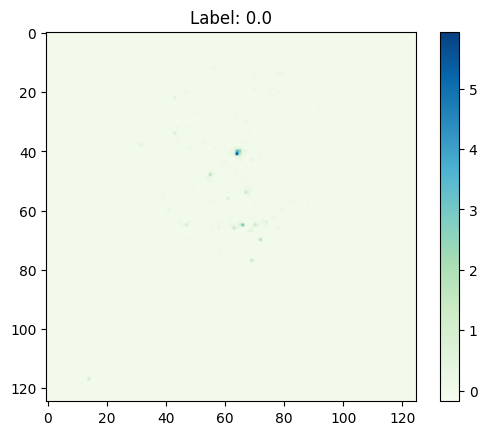

In [ ]:
import matplotlib.pyplot as plt

X_jets = np.stack([
    np.array(
        [item for sublist1 in x for sublist2 in sublist1 for item in sublist2], 
        dtype=np.float32
    ).reshape(len(x), len(x[0]), len(x[0][0])) 
    for x in df_batch['X_jets'].values
])

index = 0
image = X_jets[index]

plt.imshow(image[1], cmap='GnBu')  # Display the first layer of the 3D array
plt.colorbar()
plt.title(f"Label: {df_batch.iloc[index]['y']}")
plt.show()

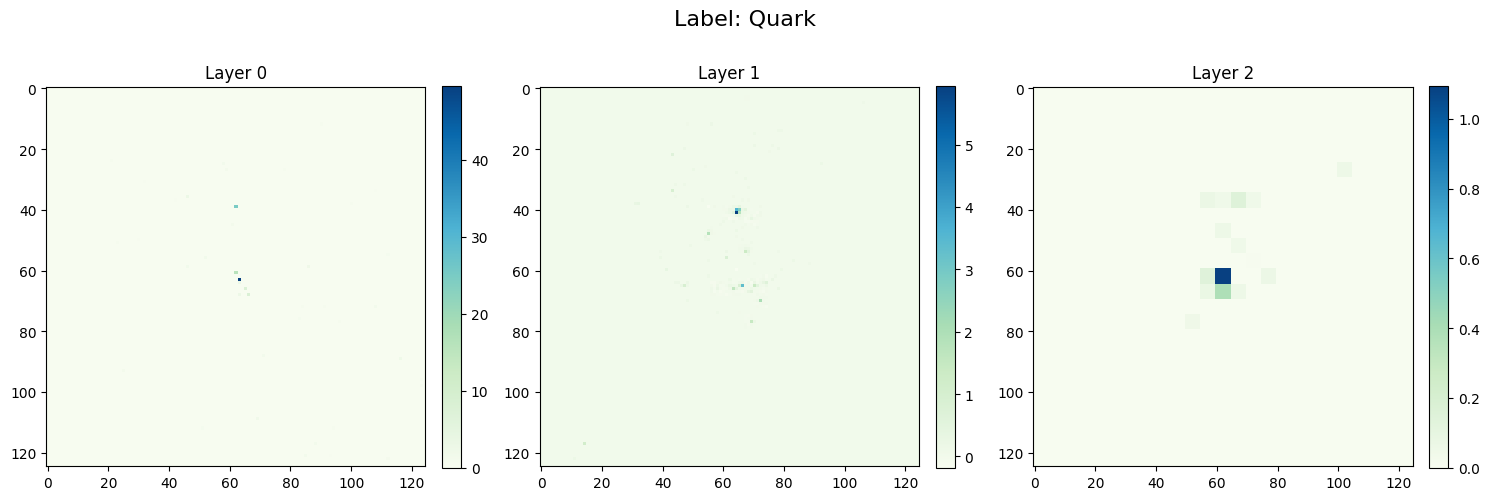

In [ ]:
index = 0
image = X_jets[index]
label = df_batch.iloc[index]['y']
label_str = "Quark" if label == 0.0 else "Gluon"

# Display each layer separately
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

im0 = ax[0].imshow(image[0], cmap='GnBu')
ax[0].set_title("Layer 0")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(image[1], cmap='GnBu')
ax[1].set_title("Layer 1")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(image[2], cmap='GnBu')
ax[2].set_title("Layer 2")
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Add a single title above all subplots
fig.suptitle(f"Label: {label_str}", fontsize=16, y=1.00)

plt.tight_layout()
plt.show()

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

# Assign folder containing the batch files
batch_folder = "/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540"

# Create a new folder called X_jets inside the batch_folder
x_jets_folder = os.path.join(batch_folder, "X_jets")
os.makedirs(x_jets_folder, exist_ok=True)

# Loop through all the batch files, extract X_jets, and save them
for i in range(1, 22):  # There are 21 batcheas of parquets
    batch_file = os.path.join(batch_folder, f"QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_batch_{i}.parquet")
    df_batch = pd.read_parquet(batch_file)

    X_jets = np.stack([
        np.array(
            [item for sublist1 in x for sublist2 in sublist1 for item in sublist2], 
            dtype=np.float32
        ).reshape(len(x), len(x[0]), len(x[0][0])) 
        for x in df_batch['X_jets'].values
    ])
    
    # Save the extracted X_jets data as a parquet file in the X_jets folder
    X_jets_table = pa.Table.from_pandas(pd.DataFrame(X_jets.reshape(X_jets.shape[0], -1)))
    pq.write_table(X_jets_table, os.path.join(x_jets_folder, f"X_jets_batch_{i}.parquet"))

In [ ]:
# Set the existing folder for X_jets batches
batch_folder = "/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540"
x_jets_folder = os.path.join(batch_folder, "X_jets")

# Read and concatenate all the saved X_jets parquet files
X_jets_list = []

for i in range(1, 22):  # There are 21 batches in this folder
    x_jets_batch_file = os.path.join(x_jets_folder, f"X_jets_batch_{i}.parquet")
    X_jets_batch = pd.read_parquet(x_jets_batch_file).values
    print(f"Reading and appending X_jets_batch_{i}.parquet")
    X_jets_list.append(X_jets_batch.reshape(-1, 125, 125, 3))

X_jets_combined = np.concatenate(X_jets_list, axis=0)
del X_jets_list

# Combine all the pt, m0, and y values from the original dataframes
df_all_batches = pd.concat([pd.read_parquet(os.path.join(batch_folder, f"QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_batch_{i}.parquet")) for i in range(1, 22)], ignore_index=True)
pt_m0_all = df_all_batches[['pt', 'm0']].values
y_all = df_all_batches['y'].values

Reading and appending X_jets_batch_1.parquet
Reading and appending X_jets_batch_2.parquet
Reading and appending X_jets_batch_3.parquet
Reading and appending X_jets_batch_4.parquet
Reading and appending X_jets_batch_5.parquet
Reading and appending X_jets_batch_6.parquet
Reading and appending X_jets_batch_7.parquet
Reading and appending X_jets_batch_8.parquet
Reading and appending X_jets_batch_9.parquet
Reading and appending X_jets_batch_10.parquet
Reading and appending X_jets_batch_11.parquet
Reading and appending X_jets_batch_12.parquet
Reading and appending X_jets_batch_13.parquet
Reading and appending X_jets_batch_14.parquet
Reading and appending X_jets_batch_15.parquet
Reading and appending X_jets_batch_16.parquet
Reading and appending X_jets_batch_17.parquet
Reading and appending X_jets_batch_18.parquet
Reading and appending X_jets_batch_19.parquet
Reading and appending X_jets_batch_20.parquet
Reading and appending X_jets_batch_21.parquet


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_data(X_jets, pt_m0, y, test_size=0.2, random_state=42):
    scaler = StandardScaler()
    pt_m0_normalized = scaler.fit_transform(pt_m0)

    X_train, X_test, y_train, y_test, pt_m0_train, pt_m0_test = train_test_split(X_jets, y, pt_m0_normalized, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test, pt_m0_train, pt_m0_test

# Use the combined X_jets, pt_m0, and y values in the prepare_data function
X_train, X_test, y_train, y_test, pt_m0_train, pt_m0_test = prepare_data(X_jets_combined, pt_m0_all, y_all)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.optimizers import SGD

def create_model(input_shape_jets=(125, 125, 3), input_shape_pt_m0=(2,)):
    # CNN for X_jets
    input_jets = Input(shape=input_shape_jets)
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='gelu')(input_jets)
    batch_norm1 = BatchNormalization()(conv1)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(batch_norm1)
    dropout1 = Dropout(0.3)(maxpool1)
    
    depthwise_conv1 = DepthwiseConv2D(kernel_size=(3, 3), activation='gelu')(dropout1)
    batch_norm2 = BatchNormalization()(depthwise_conv1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(batch_norm2)
    dropout2 = Dropout(0.5)(maxpool2)

    depthwise_conv2 = DepthwiseConv2D(kernel_size=(3, 3), activation='gelu')(dropout2)
    batch_norm3 = BatchNormalization()(depthwise_conv2)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(batch_norm3)
    dropout3 = Dropout(0.5)(maxpool3)

    flatten_jets = Flatten()(dropout3)

    # Fully connected network for pt and m0
    input_pt_m0 = Input(shape=input_shape_pt_m0)
    dense_pt_m0 = Dense(32, activation='gelu')(input_pt_m0)

    # Concatenate the outputs of both networks
    merged = concatenate([flatten_jets, dense_pt_m0])

    # Add final dense layers and output
    dense1 = Dense(128, activation='gelu')(merged)
    batch_norm4 = BatchNormalization()(dense1)
    dropout4 = Dropout(0.5)(batch_norm4)
    
    dense2 = Dense(64, activation='relu')(dropout4)
    batch_norm5 = BatchNormalization()(dense2)
    dropout5 = Dropout(0.5)(batch_norm5)

    output = Dense(1, activation='sigmoid')(dropout5)

    # Create the model
    model = Model(inputs=[input_jets, input_pt_m0], outputs=output)
    # Use SGD optimizer with default parameters
    sgd_optimizer = SGD(learning_rate=0.01, momentum=0.6)
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model()

In [ ]:
def train_model(model, X_train, pt_m0_train, y_train, batch_size=32, epochs=20, validation_split=0.2):
    history = model.fit([X_train, pt_m0_train], y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    return history

history = train_model(model, X_train, pt_m0_train, y_train)

Epoch 1/20
951/951 [==============================] - 28s 16ms/step - loss: 0.6531 - accuracy: 0.6393 - val_loss: 0.8415 - val_accuracy: 0.4884
Epoch 2/20
951/951 [==============================] - 13s 14ms/step - loss: 0.6233 - accuracy: 0.6651 - val_loss: 0.8141 - val_accuracy: 0.4940
Epoch 3/20
951/951 [==============================] - 13s 14ms/step - loss: 0.6146 - accuracy: 0.6730 - val_loss: 0.8876 - val_accuracy: 0.4884
Epoch 4/20
951/951 [==============================] - 13s 14ms/step - loss: 0.6109 - accuracy: 0.6746 - val_loss: 0.7593 - val_accuracy: 0.5350
Epoch 5/20
951/951 [==============================] - 13s 14ms/step - loss: 0.6035 - accuracy: 0.6841 - val_loss: 0.9764 - val_accuracy: 0.4886
Epoch 6/20
951/951 [==============================] - 13s 14ms/step - loss: 0.5995 - accuracy: 0.6879 - val_loss: 0.8596 - val_accuracy: 0.4990
Epoch 7/20
951/951 [==============================] - 13s 14ms/step - loss: 0.5993 - accuracy: 0.6897 - val_loss: 0.8571 - val_accuracy:

In [ ]:
def evaluate_model(model, X_test, pt_m0_test, y_test):
    test_loss, test_accuracy = model.evaluate([X_test, pt_m0_test], y_test)
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, X_test, pt_m0_test, y_test)

298/298 [==============================] - 1s 5ms/step - loss: 0.9427 - accuracy: 0.5127
Test loss: 0.9426882863044739, Test accuracy: 0.5127261281013489


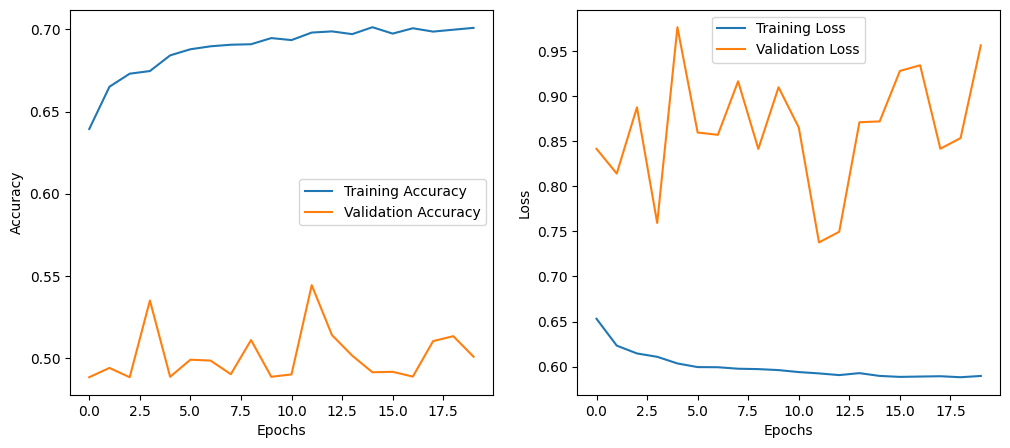

298/298 [==============================] - 1s 4ms/step


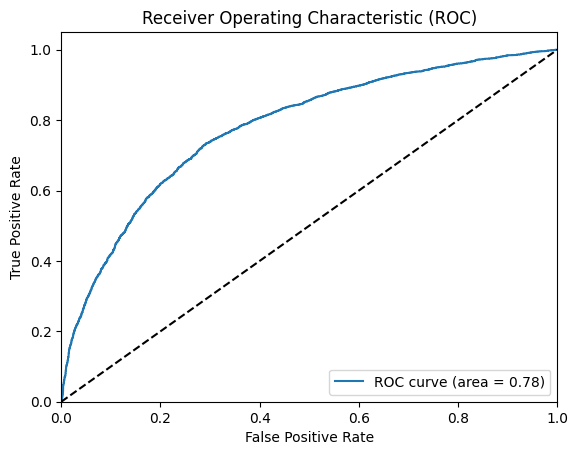

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_metrics(history, model, X_test, pt_m0_test, y_test):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate the ROC-AUC score
    y_pred = model.predict([X_test, pt_m0_test])
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC-AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_metrics(history, model, X_test, pt_m0_test, y_test)

In [ ]:
# Save the model weights
model.save_weights('/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540/model/jet0_run1.h5')